# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [18]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

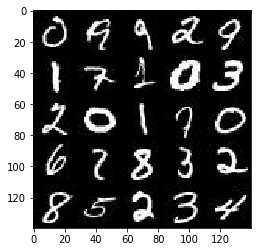

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

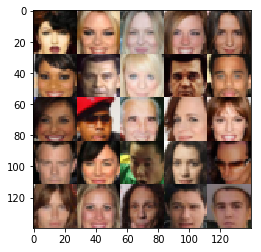

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [22]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64,5,strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=0.8)
        #14x14x64
        #print(relu1)
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=0.8)
        #print(relu2)
        #7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=0.8)
        # size 4x4x256
        
       #x4 = tf.layers.conv2d(drop3, 512, 5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        #drop4 = tf.nn.dropout(relu4, keep_prob=0.8)
        
        #size 2x2x256
        # Flatten
        
        flat = tf.contrib.layers.flatten(drop3)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.5)
        #print(x1)
        # 7*7*512 now
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha* x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        #print(x2)
        # 7*7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        #print(x3)
        # 14*14*128 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits)
        # 28*28*5 now
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss=d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in (get_batches(batch_size)):
                # TODO: Train Model
                
                steps += 1
                
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z:batch_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                 input_real:batch_images,
                                                   lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                 input_real:batch_images,
                                                   lr: learning_rate})
                # Every 100 batches, get the loss and print them out
                if (steps % 10 == 0):
                    
                    train_loss_d = sess.run(d_loss, {input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                             "Discriminator Loss: {:.4f}...".format(train_loss_d),
                             "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if (steps %100 ==0 ):
                    
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
                    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1871... Generator Loss: 3.7273
Epoch 1/2... Discriminator Loss: 2.3056... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.6836... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.8553... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 1.8485... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.6879
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 1.0273


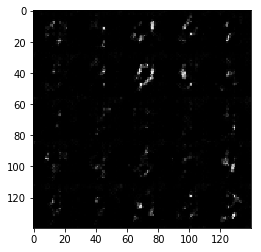

Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.6921
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 0.6147
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.7373


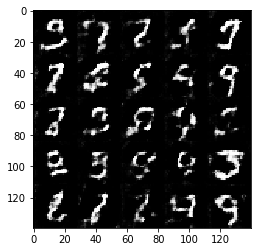

Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 1.4264
Epoch 1/2... Discriminator Loss: 1.3241... Generator Loss: 0.7206


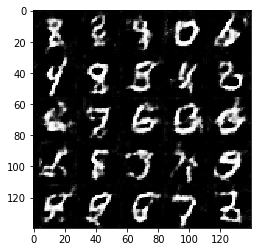

Epoch 1/2... Discriminator Loss: 1.4449... Generator Loss: 1.2081
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.5802
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.5327... Generator Loss: 1.4013
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 1.2349


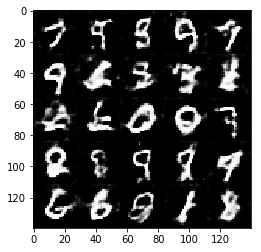

Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 1.7178... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.1827
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.8961
Epoch 1/2... Discriminator Loss: 1.6565... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.7186
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.9143


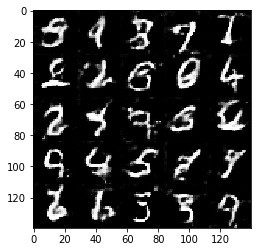

Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.1727
Epoch 2/2... Discriminator Loss: 1.2884... Generator Loss: 1.1320
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.3352... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.9321
Epoch 2/2... Discriminator Loss: 1.5669... Generator Loss: 0.4136
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 1.6752
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.8152


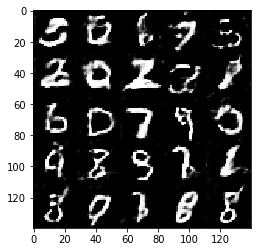

Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 1.3855
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.5842
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 1.4318
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.8825


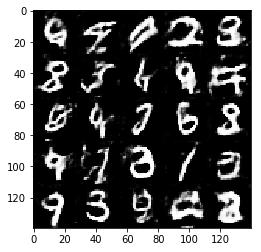

Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 1.6226
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 1.3626
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 1.7350
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 1.1426
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 1.0752
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 1.4834
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 1.7441
Epoch 2/2... Discriminator Loss: 1.6926... Generator Loss: 0.3404
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 1.2630


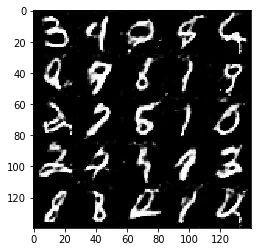

Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.8885
Epoch 2/2... Discriminator Loss: 1.4962... Generator Loss: 2.3757


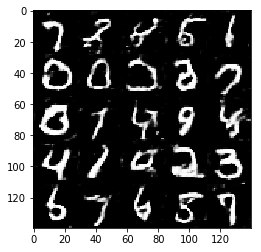

Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 1.6050
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 1.2277
Done


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
print("Done")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1898... Generator Loss: 2.9113
Epoch 1/1... Discriminator Loss: 1.9432... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 2.1712... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.7339


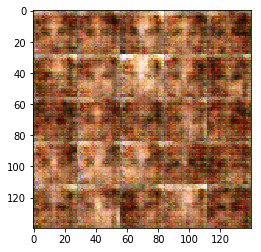

Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 2.3481... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8478


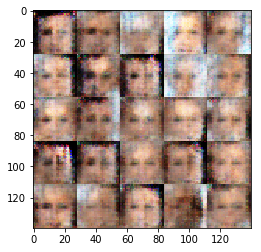

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.6112... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.6819


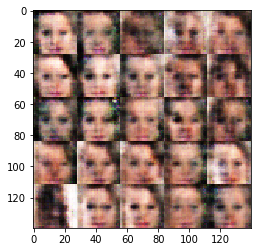

Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6912


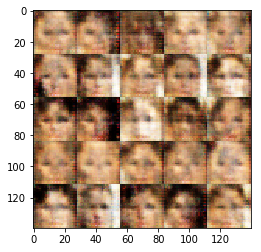

Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7392


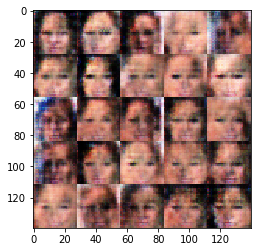

Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.6748... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6310


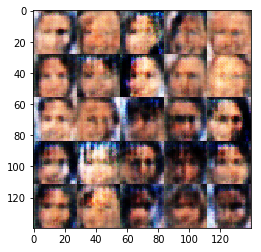

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8110


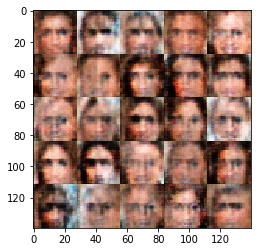

Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7662


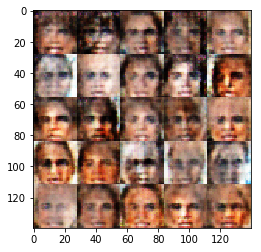

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5881... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.5456


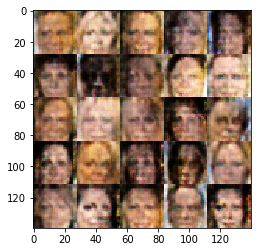

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9085


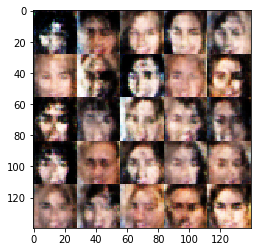

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.8365


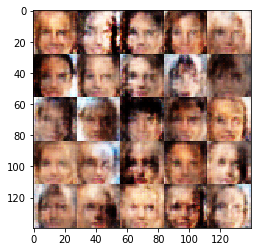

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8660


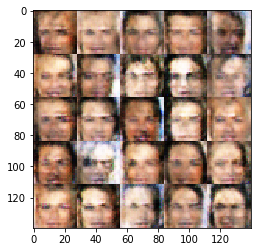

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.9075


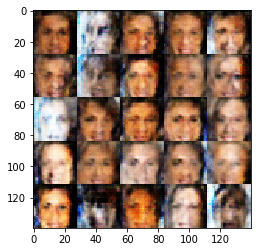

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8506


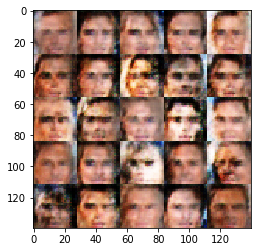

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9118


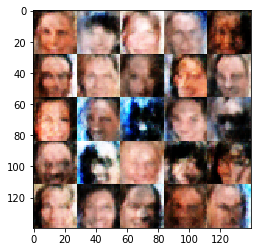

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8296


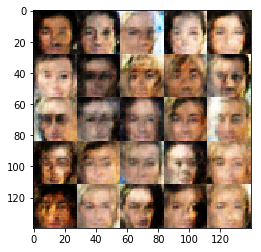

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8748


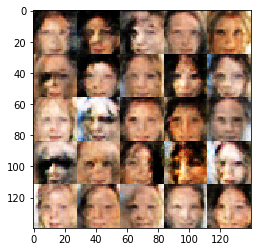

Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7479


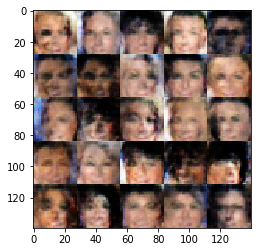

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7926


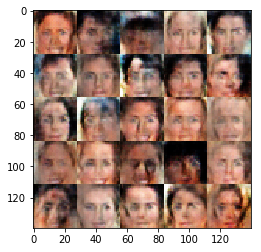

Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8236


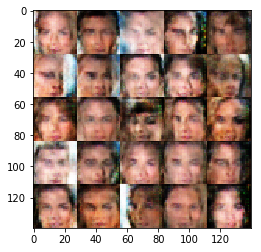

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8059


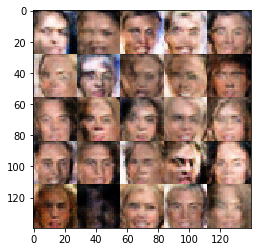

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7917


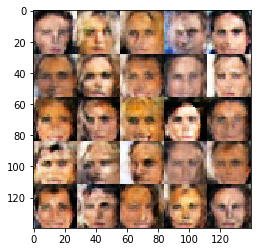

Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8188


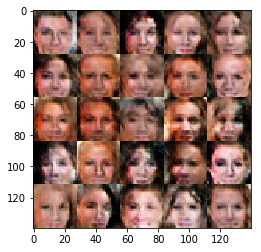

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8968


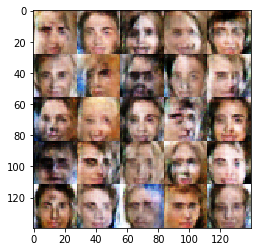

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.0431


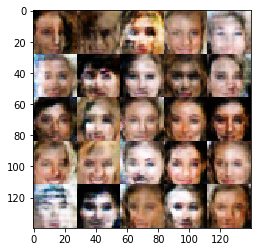

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8128


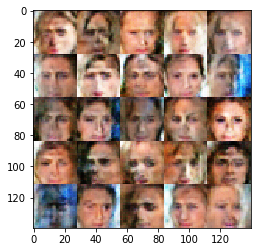

Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7414


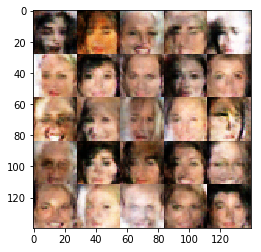

Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7972


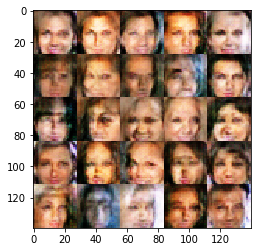

Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.5067


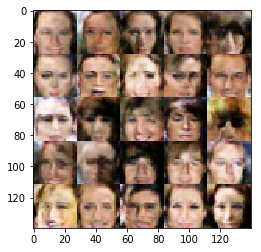

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.9201


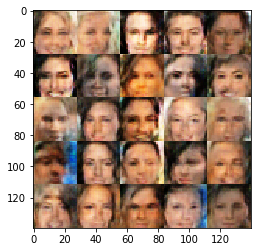

Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8647
Done


In [33]:
batch_size =64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
print("Done")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.